# Figure 5: Critical distance plot of the accuracy obtained with each augmentation for the 32x32 and 64x64 cases.

[:simple-jupyter: :material-download:](/papers/imc23/notebooks/figure5_ucdavis_augmentations_comparison.ipynb)

In [1]:
import pathlib

import autorank
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
folder_path = pathlib.Path(
    "./campaigns/ucdavis-icdm19/augmentation-at-loading-with-dropout/campaign_summary/augment-at-loading-with-dropout/"
)

In [3]:
df = pd.concat(
    [
        pd.read_parquet(folder_path / f"runsinfo_flowpic_dim_{flowpic_dim}.parquet")
        for flowpic_dim in (32, 64, 1500)
    ]
)

In [4]:
def prepare_data(dat, test_split):
    res = dat.query("test_split_name == @test_split & flowpic_dim != 1500")
    res = res[["aug_name", "split_index", "flowpic_dim", "seed", "acc"]]
    res["id"] = (
        "split_index"
        + res["split_index"].astype(str)
        + "_seed"
        + res["seed"].astype(str)
        + "_flowpicdim"
        + res["flowpic_dim"].astype(str)
    )
    res = res[["aug_name", "id", "acc"]]
    return res.sort_values(["aug_name", "id"])


def get_ranks(df, test_split, force_ranks=True):
    df1 = prepare_data(df, test_split)
    df1 = df1.pivot(columns="aug_name", index="id").reset_index(drop=True)
    df1.columns = df1.columns.get_level_values(1)
    new_df = pd.DataFrame(
        {
            "changertt": df1["changertt"].values,
            "colorjitter": df1["colorjitter"].values,
            "horizontalflip": df1["horizontalflip"].values,
            "noaug": df1["noaug"].values,
            "packetloss": df1["packetloss"].values,
            "rotate": df1["rotate"].values,
            "timeshift": df1["timeshift"].values,
        }
    )
    replacement = {
        "noaug": "No augmentation",
        "horizontalflip": "Horizontal flip",
        "rotate": "Rotate",
        "timeshift": "Time shift",
        "colorjitter": "Color jitter",
        "changertt": "Change RTT",
        "packetloss": "Packet Loss",
    }
    new_df = new_df.rename(columns=replacement)
    if force_ranks:
        return autorank.autorank(new_df, force_mode="nonparametric")
    else:
        return autorank.autorank(new_df)

Tests for normality and homoscedacity are ignored for test selection, forcing nonparametric tests
Tests for normality and homoscedacity are ignored for test selection, forcing nonparametric tests


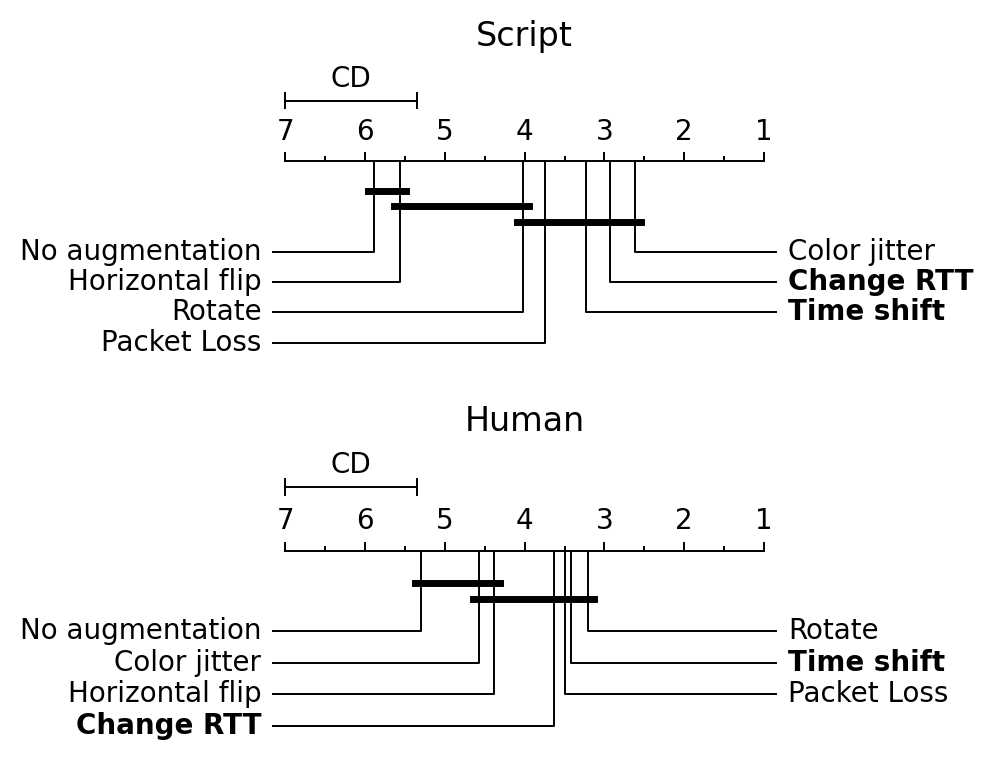

In [5]:
res_script = get_ranks(df, "test-script", force_ranks=True)
res_human = get_ranks(df, "test-human", force_ranks=True)

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(5, 4))
ax = axes[0]
autorank.plot_stats(res_script, ax=ax)
ax.set_title("Script")
for obj in ax._children:
    if isinstance(obj, mpl.text.Text) and obj.get_text() in (
        "Change RTT",
        "Time shift",
    ):
        obj.set_fontweight("bold")

ax = axes[1]
autorank.plot_stats(res_human, ax=ax)
ax.set_title("Human")
for obj in ax._children:
    if isinstance(obj, mpl.text.Text) and obj.get_text() in (
        "Change RTT",
        "Time shift",
    ):
        obj.set_fontweight("bold")

plt.tight_layout()
plt.savefig("augmentations_rank_comparison.png", bbox_inches="tight", dpi=300)

In [6]:
autorank.create_report(res_human)

The statistical analysis was conducted for 7 populations with 30 paired samples.
The family-wise significance level of the tests is alpha=0.050.
We failed to reject the null hypothesis that the population is normal for all populations (minimal observed p-value=0.008). Therefore, we assume that all populations are normal.
We applied Bartlett's test for homogeneity and reject the null hypothesis (p=0.030) that thedata is homoscedastic. Thus, we assume that our data is heteroscedastic.
Because we have more than two populations and the populations are normal but heteroscedastic, we use the non-parametric Friedman test as omnibus test to determine if there are any significant differences between the mean values of the populations. We use the post-hoc Nemenyi test to infer which differences are significant. We report the mean value (M), the standard deviation (SD) and the mean rank (MR) among all populations over the samples. Differences between populations are significant, if the difference

In [7]:
autorank.create_report(res_script)

The statistical analysis was conducted for 7 populations with 30 paired samples.
The family-wise significance level of the tests is alpha=0.050.
We rejected the null hypothesis that the population is normal for the populations Rotate (p=0.001), Packet Loss (p=0.002), and Time shift (p=0.002). Therefore, we assume that not all populations are normal.
Because we have more than two populations and the populations and some of them are not normal, we use the non-parametric Friedman test as omnibus test to determine if there are any significant differences between the median values of the populations. We use the post-hoc Nemenyi test to infer which differences are significant. We report the median (MD), the median absolute deviation (MAD) and the mean rank (MR) among all populations over the samples. Differences between populations are significant, if the difference of the mean rank is greater than the critical distance CD=1.644 of the Nemenyi test.
We reject the null hypothesis (p=0.000) of